# Example of generating data for training/evaluation
---


## Table of Contents

1. [Data generator for training CFO Correction Network](#cfo_data_generator)
2. [Data generator for training Equalization](#equalization)
3. [Data generator for training Demod + Decoder](#decoder)
4. [Data generator for training End to End](#end2end)

## Environment setup

In [1]:
# Import packages from other direction. It is necessary if the project is structured as:
# project
# ├── notebooks
# │   └── ipython_notebook.ipynb
# ├── python_package
# │   ├──__init__.py
# │   ├── models.py
# ├── README.md
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from radioml.dataset import RadioDataGenerator
from radioml.utils import visualize_signals

# For visualization
import imageio
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
sns.set_style("white")
%matplotlib inline

## Define Parameters

In [3]:
NUM_PACKETS  = 10
PREAMBLE_LEN = 40
DATA_LEN     = 200
CHANNEL_LEN = 1
OMEGA      = 1/50
SNR_train  = 10.0 

## Visualization Funcs

In [4]:
plt.ioff()

def _convert_fig_to_img(fig):
    """Convert figure to image."""
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

def visualize_cfo(radio, omega, snr):
    """Visualize the effect of Carrier Offset Frequency."""
    [preambles, preambles_conv], \
    cfo_corrected_preamble = next(radio.cfo_data_generator(omega, 
                                                           snr, 
                                                           batch_size=4))
    symbols, groundtruths = np.unique(preambles.view(np.complex),return_inverse=True)

    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10, 5))
    st = fig.suptitle("Omega = %.3f || SNR_dB = %.2f " % (omega, snr))

    visualize_signals(left_ax, 
                     x=preambles_conv[...,0].flatten(), 
                     y=preambles_conv[...,1].flatten(),
                     groundtruths=groundtruths, 
                     title="Before CFO Correction")
    visualize_signals(right_ax, 
                     x=cfo_corrected_preamble[...,0].flatten(), 
                     y=cfo_corrected_preamble[...,1].flatten(),
                     groundtruths=groundtruths, 
                     title="After CFO Correction")
    img = _convert_fig_to_img(fig)
    return img
    
    
def visualize_equalization(radio, omega, snr):
    """Visualize the effect of Symbol Inteference."""
    
    examples = next(radio.equalization_data_generator(omega, 
                                                      snr, 
                                                      batch_size=4, 
                                                      num_cpus=8))
    [preambles, cfo_corrected_preamble, cfo_corrected_data], \
    [equalized_data, modulated_packet] = examples   
    
    symbols, groundtruths = np.unique(modulated_packet.view(np.complex),return_inverse=True)

    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10,5))
    st = fig.suptitle("Number of Channels = %d" % radio.channels_len)
    
    visualize_signals(left_ax, 
                      cfo_corrected_data[...,0].flatten(),
                      cfo_corrected_data[...,1].flatten(), 
                      groundtruths,
                      title="Before Equalization", 
                      min_val=-3,max_val=3)
    visualize_signals(right_ax, 
                      equalized_data[...,0].flatten(),
                      equalized_data[...,1].flatten(),
                      groundtruths,
                      title="After Equalization", 
                      min_val=-3, max_val=3)
    img = _convert_fig_to_img(fig)
    return img

def visualize_demod_n_decode(radio, omega, snr):
    
    [equalized_data, modulated_data], \
    data_estimate = next(radio.ecc_data_generator(omega, 
                                                  snr, 
                                                  batch_size=4))
    symbols, groundtruths = np.unique(modulated_data.view(np.complex), return_inverse=True)
    fig, ax = plt.subplots(1, 1)
    
    visualize_signals(ax, 
                      equalized_data[...,0].flatten(),
                      equalized_data[...,1].flatten(), 
                      groundtruths,
                      title="Equalized singals at $SNR_{dB}$ = %.2f dB"%snr)

    img = _convert_fig_to_img(fig)
    return img

## Example of data generator for training CFO Correction  <a class="anchor" id="cfo_data_generator"></a>


In [5]:
%%time
radio = RadioDataGenerator(DATA_LEN, PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')
generator = radio.cfo_data_generator(OMEGA, SNR_train, batch_size=32)

for i in range(3):
    one_batch = next(generator)
    [preambles, preambles_conv], cfo_corrected_preamble = one_batch

CPU times: user 89.1 ms, sys: 42.1 ms, total: 131 ms
Wall time: 696 ms


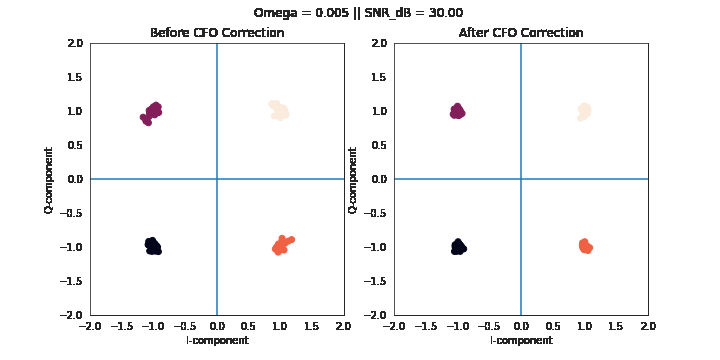

In [6]:
num_taps = 1
fnames = []
for modulation_scheme in ['QPSK']:
    radio = RadioDataGenerator(DATA_LEN, PREAMBLE_LEN, num_taps, modulation_scheme)
    # Save and Display the animated result
    
    filename = './figures/cfo_%s.gif' % modulation_scheme
    imageio.mimsave(filename, 
                    [visualize_cfo(radio, omega, 30.0)
                    for omega in [1/200, 1/100, 1/90, 1/80, 1/70, 1/60, 1/50, 1/40, 1/20]] , 
                    fps=3)
    
with open(filename,'rb') as f:
    display(Image(data=f.read(), format='png'))

## Example of data generatorfor training Equalization  <a class="anchor" id="equalization"></a>


In [7]:
%%time
radio = RadioDataGenerator(DATA_LEN,PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')
generator = radio.equalization_data_generator(OMEGA, SNR_train, batch_size=32)

for i in range(3):
    one_batch = next(generator)
    [preambles, cfo_corrected_preamble, cfo_corrected_preamble], channels_etimates = one_batch

CPU times: user 95.6 ms, sys: 75.4 ms, total: 171 ms
Wall time: 786 ms


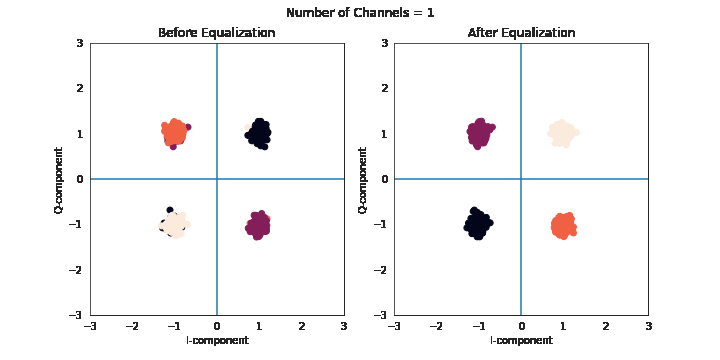

In [9]:
# Visualize equalization data
fnames=[]

CHANNEL_TAPS = [1, 2, 3, 4, 5]
for modulation_scheme in ['QPSK']:
    radios = [RadioDataGenerator(DATA_LEN, PREAMBLE_LEN, 
                                 channel_tap, 
                                 modulation_scheme)
              for channel_tap in CHANNEL_TAPS]
    
    filename = './figures/channel_inference_%s.gif'%modulation_scheme
    imageio.mimsave(filename, 
                    [visualize_equalization(radio, 1/300, 20.0) 
                     for radio in radios], fps=2)
    fnames.append(filename)

with open(filename,'rb') as f:
    display(Image(data=f.read(), format='png'))

## Data generator for training Demod + Decoder <a class="anchor" id="decoder"></a>

In [10]:
%%time
radio = RadioDataGenerator(DATA_LEN, PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')
generator = radio.ecc_data_generator(OMEGA, SNR_train, batch_size=32)

for i in range(3):
    one_batch = next(generator)
    equalized_data, data_estimate = one_batch

CPU times: user 79.5 ms, sys: 69.9 ms, total: 149 ms
Wall time: 749 ms


In [11]:
SNRs = [0.0,  3.0, 5.0, 7.0, 10.0, 13.0, 15.0, 17.0, 20.0, 30.0]

radio = RadioDataGenerator(DATA_LEN, PREAMBLE_LEN, 1, 
                           modulation_scheme='QPSK')

imageio.mimsave('./figures/error_correction.gif', 
                   [visualize_demod_n_decode(radio, 1/1000, snr) for snr in SNRs], 
                   fps=1)
display(Image(url='./figures/error_correction.gif'))

/home/dat/miniconda/envs/radioml/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


## Data generator for training End to End Net <a class="anchor" id="end2end"></a>

In [12]:
%%time
radio = RadioDataGenerator(DATA_LEN,PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')
generator = radio.end2end_data_generator(OMEGA, SNR_train, batch_size=32)

for i in range(3):
    one_batch = next(generator)
    [preambles, corrupted_packets], data_etimates = one_batch

CPU times: user 78.5 ms, sys: 101 ms, total: 180 ms
Wall time: 680 ms
